# Case Study: Palladium Catalyzed AAA reactions 
#### Goal: Apply RCCR algorithm to find linearly modellable clusters

In [19]:
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from prepare_dataset import prepare_dataset
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 16})

sys.path.append('../src')
import rccr


### Dataset preparation

read in data

In [2]:
df = prepare_dataset('../data/Palladium_Database.xlsx')

split data, transform to high variance principal components

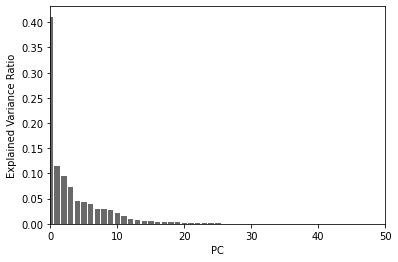

In [3]:
df_train, df_test = train_test_split(df,test_size=0.1, random_state=25)

X_train = df_train.iloc[:,6:]
X_test = df_test.iloc[:,6:]
y_train = df_train['DDG']
y_test = df_test['DDG']

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA().fit(X_train_scaled)
pcs = pca.transform(X_train_scaled)[:,:20]
pcs_test = pca.transform(X_test_scaled)[:,:20]

plt.bar(range(0,len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, color='dimgrey')
plt.xlabel('PC')
plt.ylabel('Explained Variance Ratio')
plt.xlim(0,50)
plt.show()

### Apply RCCR to find clusters

elbow plot to find ideal # of clusters

In [42]:
cluster_list = []
average_r2_list = []
r2_list = []
full_r2 = []
for i in range(2,10):
    print(i)
    new_labels = rccr.get_average_clusters(pcs,y_train.values,n_clusters=i,iterations=8,max_iteration_cluster=5, plot=False)
    cr_meas, cr_pred, clusters = rccr.cr_fit(pcs,y_train.values,labels=new_labels)
    full_r2.append(r2_score(cr_meas,cr_pred))
    temp = []
    for cluster in np.unique(clusters):
        index = clusters == cluster
        r2_list.append(r2_score(cr_meas[index[:,0]],cr_pred[index[:,0]]))
        cluster_list.append(i)
        temp.append(r2_score(cr_meas[index[:,0]],cr_pred[index[:,0]]))
    average_r2_list.append(np.average(temp))

2
Initial r2 0.18576213620993132
Initial r2 0.18576213620993132
Initial r2 0.18576213620993132
Initial r2 0.18576213620993132
Iteration 0 0.4515976270282599
Iteration 0 0.45086911895880605
Iteration 0 0.4456348012738958
Iteration 0 0.4464839770823179
Iteration 1 0.5460410363489065
Iteration 1 0.5267041849894544
Iteration 1 0.4844157502132264
Iteration 1 0.4841602235187204
Iteration 2 0.5590304875088977
Iteration 2 0.5577958006898824
Iteration 2 0.4854262112390615
Iteration 2 0.485613495938581
Iteration 3 0.5636730342987757
Iteration 3 0.5625202619606615
Iteration 3 0.4855180858888309
Iteration 3 0.48563947978804256
Final r2 0.5660730392505344
Final r2 0.5661250437144228
Final r2 0.48563947978804256
Final r2 0.48563947978804256
Initial r2 0.18576213620993132
Initial r2 0.18576213620993132
Initial r2 0.18576213620993132
Initial r2 0.18576213620993132
Iteration 0 0.43281526206758214
Iteration 0 0.4068915954155269
Iteration 0 0.4463895808855302
Iteration 0 0.46339926663688324
Iteration 1 0

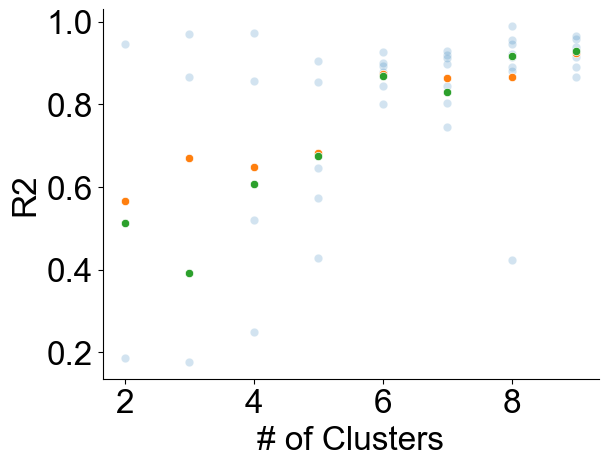

In [12]:
sns.scatterplot(x=cluster_list,y=r2_list, alpha=0.2)
sns.scatterplot(x=range(2,10),y=average_r2_list)
sns.scatterplot(x=range(2,10), y=full_r2)
plt.xlabel('# of Clusters')
plt.ylabel('R2')
plt.show()

In [ ]:
new_labels = rccr.get_average_clusters(pcs,y_train.values,n_clusters=6,iterations=80,max_iteration_cluster=5, plot=True, num_jobs=-1)

Cluster 0 R2 0.8994428460343854 coeff [0.47892342244777814][4] int 1.8529782151393577
Cluster 1 R2 0.9330823817077356 coeff [0.463415403027197][4] int 1.3196024846107206
Cluster 2 R2 0.867302663003081 coeff [0.5530383574161923][2] int 3.083361985713271
Cluster 3 R2 0.8833522175678632 coeff [0.31672112756142207][9] int 1.6720747410006171
Cluster 4 R2 0.8216882259841276 coeff [0.6477940498852135][10] int 1.1229441840446093
Cluster 5 R2 0.9012428220214495 coeff [0.9540315389290359][13] int 1.3791262296608449


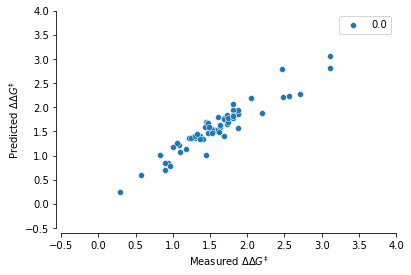

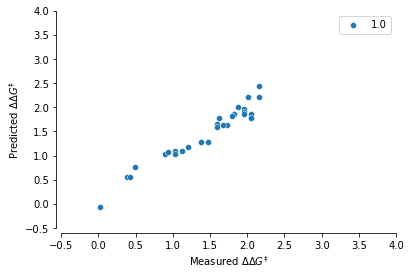

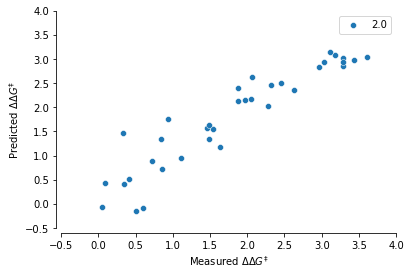

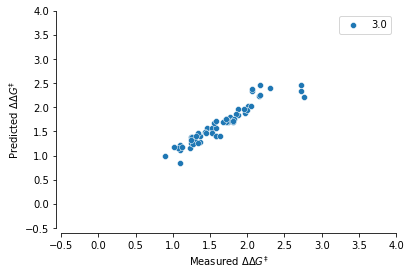

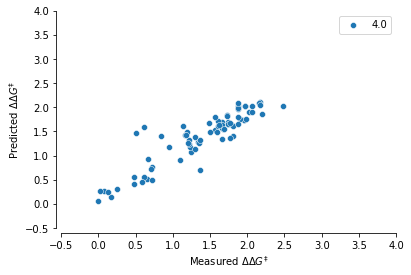

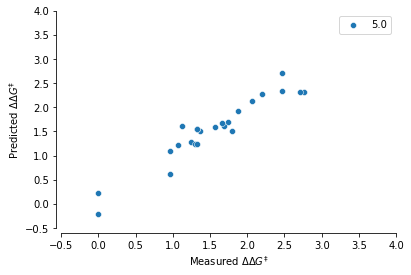

cr R2 0.876856655432764


In [ ]:
cr_meas, cr_pred, clusters = rccr.cr_fit(pcs,y_train.values,labels=new_labels)

for cluster in np.unique(clusters):
    index = clusters ==  cluster
    sns.scatterplot(x=cr_meas[tuple([index[:,0]])],y=cr_pred[tuple([index[:,0]])], label=cluster)
    plt.xlim(-0.5,4)
    plt.ylim(-0.5,4)
    sns.despine(offset=5, trim=True)

    
    plt.xlabel('Measured $\Delta\Delta G^‡$')
    plt.ylabel('Predicted $\Delta\Delta G^‡$')
    plt.show()


print("cr R2 " + str(r2_score(cr_meas, cr_pred)))

obtain alternative cluster labels for each reaction based on how it affects score

In [ ]:
array = rccr.get_possible_clusters(pcs,y_train.values, labels=new_labels, scoring='MAE')

from sklearn.preprocessing import OneHotEncoder

new_labels_array = OneHotEncoder(sparse=False).fit_transform(new_labels.reshape(-1,1))

final_array = new_labels_array+array

final_array[final_array == 2] = 1



In [ ]:
test_array = np.zeros(shape=(len(df_test),len(final_array[0])))
for cluster in range(0,len(final_array[0])):
    model = RandomForestClassifier(random_state=25).fit(X_train_scaled,final_array[:,cluster])
    test_labels = model.predict(X_test_scaled)
    test_array[:,cluster] = test_labels
    

## Visualize dataset with UMAP

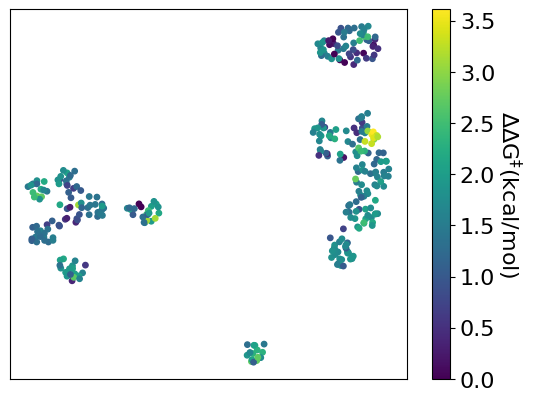

In [155]:
import umap

umap_data = umap.UMAP(n_neighbors=30,random_state=25, min_dist=0.8).fit_transform(StandardScaler().fit_transform(df.iloc[:,7:]))

plt.scatter(x=umap_data[:,0],y=umap_data[:,1], c=df['DDG'], s=15, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('ΔΔG$^‡$(kcal/mol)', rotation=270, labelpad=20)
plt.xticks([])
plt.yticks([])
plt.show()



c1
c2
c3
c4
c5
c6


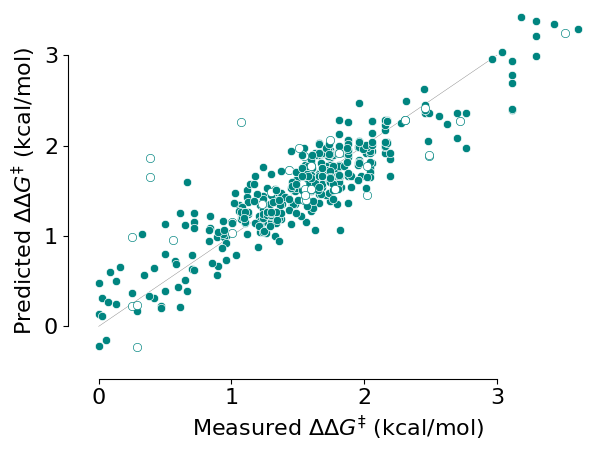

In [21]:
import pandas as pd
color_list = ['#008580', '#531C93', '#ED9B40', '#BA3B46', '#131200','#A799B7']

df = pd.read_excel('/Users/isaiahbetinol/Documents/My Manuscripts/New Regression/ACS_Catal/Data S1/results/mlr_results.xlsx', 
                   sheet_name=None)

for number, cluster in enumerate(df):
    print(cluster)
    temp_df = df[cluster]
    train = temp_df[temp_df['Class']=='Train']
    test = temp_df[temp_df['Class']=='Test']

    sns.scatterplot(x=train['Measured ΔΔG'],y=train['Predicted ΔΔG'], color='#008580')
    sns.scatterplot(x=test['Measured ΔΔG'],y=test['Predicted ΔΔG'], color='white', edgecolor='#008580')

plt.plot([0,3],[0,3],color='grey',zorder=0, linewidth=0.3)

sns.despine(offset=5, trim=True)


plt.xlabel('Measured $\Delta\Delta G^‡$ (kcal/mol)')
plt.ylabel('Predicted $\Delta\Delta G^‡$ (kcal/mol)')
plt.ylim(-0.5,3.5)
plt.tight_layout()
plt.savefig('fig.pdf')
plt.show()
